# Benchmarking Results

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

### 1. Load, Summarize, Insert

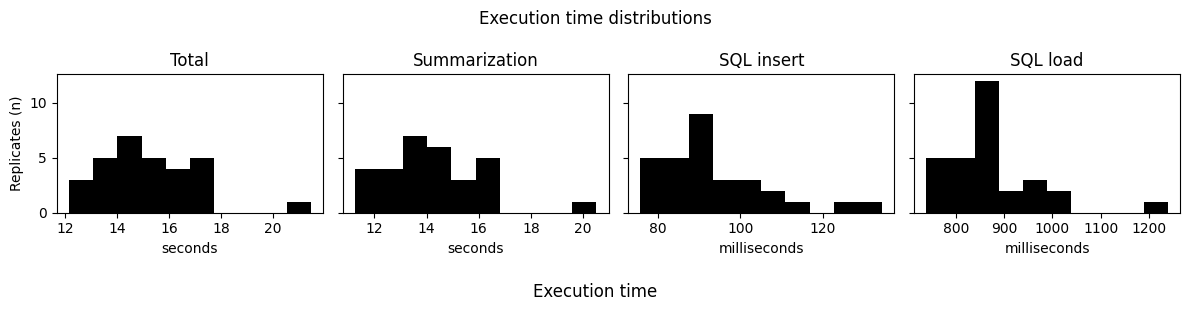

,replicate,num_abstracts,total_replicate_time,total_summarization_time,total_insert_time,total_loading_time,mean_total_time,mean_summarization_time,mean_insert_time,mean_loading_time
0,1,5,81.024608,74.159446,0.672012,6.193149,16.204922,14.831889,0.134402,1.238630
1,2,5,87.608085,82.806621,0.466438,4.335026,17.521617,16.561324,0.093288,0.867005
2,3,5,75.511175,70.447547,0.538895,4.524733,15.102235,14.089509,0.107779,0.904947
3,4,5,63.350354,58.682924,0.402112,4.265318,12.670071,11.736585,0.080422,0.853064
4,5,5,85.457751,80.822233,0.494642,4.140875,17.091550,16.164447,0.098928,0.828175


In [3]:
data = pd.read_csv('../benchmarks/load_summarize_insert/results.csv')

titles = ['Total', 'Summarization', 'SQL insert', 'SQL load']
data_types = ['mean_total_time', 'mean_summarization_time', 'mean_insert_time', 'mean_loading_time']
xlabels = ['seconds', 'seconds', 'milliseconds', 'milliseconds']
xaxis_scales = [1, 1, 10**3, 10**3]

fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True, tight_layout=True)

fig.suptitle('Execution time distributions')
fig.supxlabel('Execution time')

axs_num = 0

for title, data_type, xlabel, xaxis_scale in zip(titles, data_types, xlabels, xaxis_scales):

    axs[axs_num].set_title(title)
    axs[axs_num].set_xlabel(xlabel)
    axs[axs_num].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axs[axs_num].hist(
        data[data_type] * xaxis_scale,
        histtype='stepfilled', 
        cumulative=0,
        color='black'
    )

    axs_num += 1

axs[0].set_ylabel('Replicates (n)')

plt.show()

data.head()


### 2. Huggingface Device Map

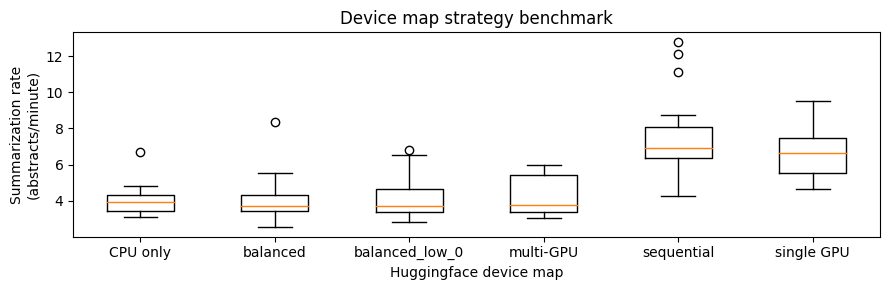

,abstract,device map strategy,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,1,CPU only,19.163196,0.052183,3.131002
1,2,CPU only,15.579454,0.064187,3.851226
2,3,CPU only,15.299519,0.065362,3.921692
3,4,CPU only,19.429485,0.051468,3.088090
4,5,CPU only,15.677886,0.063784,3.827047


In [4]:
data = pd.read_csv('../benchmarks/huggingface_device_map/results.csv')
data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60

wide_data = data.pivot(index='abstract', columns='device map strategy', values='summarization rate (abstracts/min.)')

fig, axs = plt.subplots(1, 1, figsize=(9, 3), tight_layout=True)

axs.set_title('Device map strategy benchmark')
axs.set_xlabel('Huggingface device map')
axs.set_ylabel('Summarization rate\n(abstracts/minute)')
axs.boxplot(wide_data, labels=wide_data.columns)

plt.show()

data.head()

### 3. Parallel Summarization

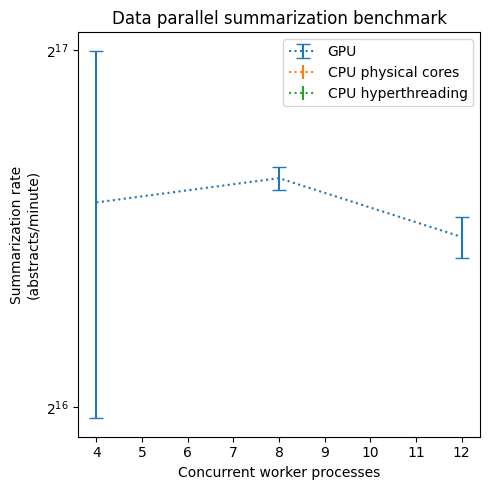

,replicate,abstracts,abstracts per worker,workers,device map strategy,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,0,120,30,4,GPU,0.189973,631.669118,37900.147088
1,1,120,30,4,GPU,0.064821,1851.251770,111075.106205
2,2,120,30,4,GPU,0.062994,1904.928809,114295.728527
3,3,120,30,4,GPU,0.065396,1834.986018,110099.161104
4,4,120,30,4,GPU,0.063064,1902.818711,114169.122645


In [5]:
data = pd.read_csv('../benchmarks/parallel_summarize/results.csv')
data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60

device_map_strategies = ['GPU', 'CPU physical cores', 'CPU hyperthreading']

fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

axs.set_title('Data parallel summarization benchmark')
axs.set_xlabel('Concurrent worker processes')
axs.set_ylabel('Summarization rate\n(abstracts/minute)')
axs.set_yscale('log', base=2)
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

for device_map_strategy in device_map_strategies:

    plot_data = data[data['device map strategy'] == device_map_strategy]

    mean = plot_data.groupby(['device map strategy', 'workers']).mean()
    mean.reset_index(inplace=True)
    
    std = plot_data.groupby(['device map strategy', 'workers']).std()
    std.reset_index(inplace=True)

    axs.errorbar(
        mean['workers'], 
        mean['summarization rate (abstracts/min.)'], 
        yerr=std['summarization rate (abstracts/min.)'],
        capsize=5,
        label=device_map_strategy,
        linestyle='dotted'
    )

plt.legend(loc='best')
plt.show()

data.head()

### 4. Model quantization

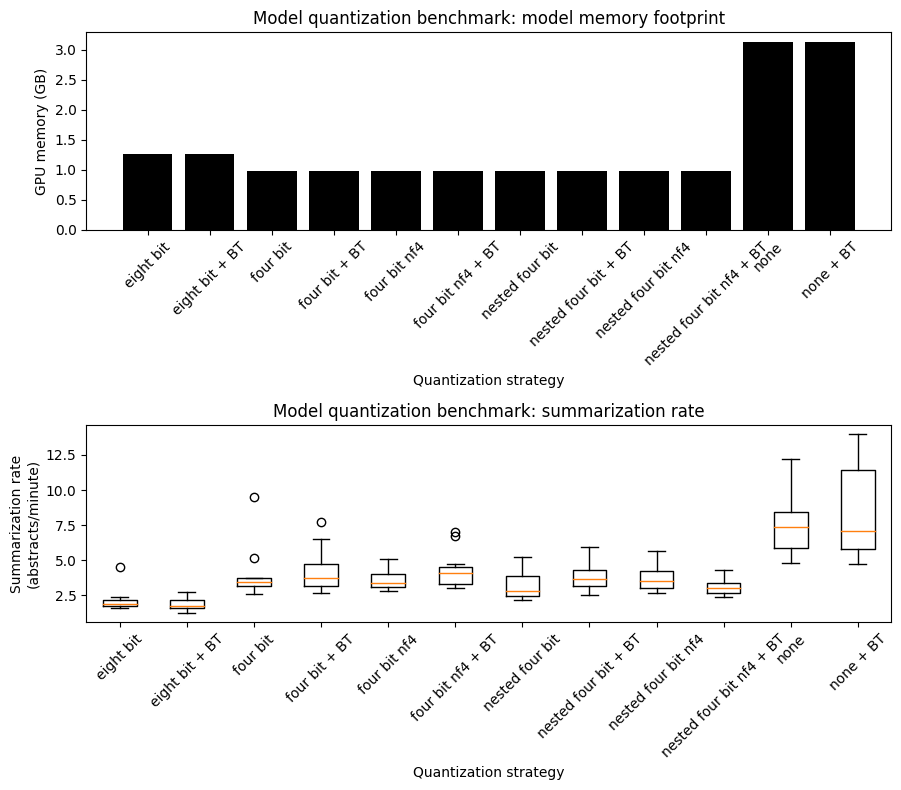

In [6]:
data = pd.read_csv('../benchmarks/model_quantization/results.csv')
data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60
data['model GPU memory footprint (GB)'] = data['model GPU memory footprint (bytes)'] / 10 ** 9

fig, axs = plt.subplots(2, 1, figsize=(9, 8), tight_layout=True)

mean_memory_footprint_data = data[['quantization strategy', 'model GPU memory footprint (GB)']].groupby('quantization strategy').mean()

axs[0].set_title('Model quantization benchmark: model memory footprint')
axs[0].set_xlabel('Quantization strategy')
axs[0].set_ylabel('GPU memory (GB)')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].bar(
    x=mean_memory_footprint_data.index, 
    height=mean_memory_footprint_data['model GPU memory footprint (GB)'],
    color='black'
)

rate_data = data[['abstract', 'quantization strategy', 'summarization rate (abstracts/min.)']]
rate_data = data.pivot(index='abstract', columns='quantization strategy', values='summarization rate (abstracts/min.)')

axs[1].set_title('Model quantization benchmark: summarization rate')
axs[1].set_xlabel('Quantization strategy')
axs[1].set_ylabel('Summarization rate\n(abstracts/minute)')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].boxplot(rate_data, labels=rate_data.columns)

plt.show()

### 5. Batched summarization

In [50]:
pd.options.mode.chained_assignment = None

data = pd.read_csv('../benchmarks/batched_summarization/results.csv')
data['summarization rate (abstracts/sec.)'] = data['summarization rate (abstracts/sec.)'].astype(str)

OOM_columns = [
    'summarization time (sec.)',
    'summarization rate (abstracts/sec.)',
    'model GPU memory footprint (bytes)',
    'max memory allocated (bytes)'
]

OOM = data[data['summarization time (sec.)'] == 'OOM']
OOM = OOM[['replicate', 'batch size', 'quantization']]
OOM_conditions = OOM.to_numpy().tolist()

for OOM_column in OOM_columns:
    for condition in OOM_conditions:

        data[OOM_column].loc[
            (data['replicate'] == condition[0]) &
            (data['batch size'] == condition[1]) &
            (data['quantization'] == condition[2])
        ] = 0

data.head(40)

,abstracts,replicate,batches,batch size,quantization,summarization time (sec.),summarization rate (abstracts/sec.),model GPU memory footprint (bytes),max memory allocated (bytes)
0,3,1,3,1,none,42.15730166435242,0.0711620497887974,3132600320,3506201600
1,3,2,3,1,none,38.40008997917175,0.0781248169373353,3132600320,3503972864
2,3,3,3,1,none,33.71662974357605,0.0889768646159417,3132600320,3499254272
3,3,4,3,1,none,31.377110719680783,0.0956110977457939,3132600320,3491389952
4,3,5,3,1,none,32.319329023361206,0.092823709237018,3132600320,3515376640
5,6,1,3,2,none,44.14935469627381,0.1359023261217994,3132600320,3726639104
6,6,2,3,2,none,41.336538314819336,0.1451500354070281,3132600320,3734365696
7,6,3,3,2,none,46.58925938606262,0.128785047864378,3132600320,3759765504
8,6,4,3,2,none,37.30806064605713,0.1608231544631121,3132600320,3700089344
9,6,5,3,2,none,40.11912941932678,0.1495545912097881,3132600320,3728409088


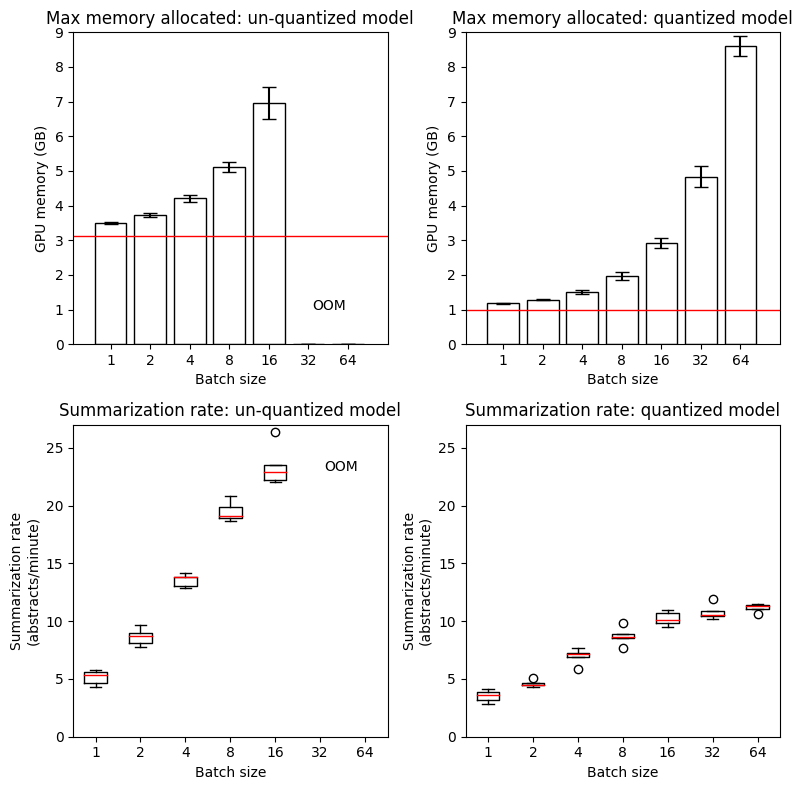

In [61]:
import math

data = pd.read_csv('../benchmarks/batched_summarization/results.csv')
data['summarization rate (abstracts/sec.)'] = data['summarization rate (abstracts/sec.)'].astype(str)

OOM_columns = [
    'summarization time (sec.)',
    'summarization rate (abstracts/sec.)',
    'model GPU memory footprint (bytes)',
    'max memory allocated (bytes)'
]

OOM = data[data['summarization time (sec.)'] == 'OOM']
OOM = OOM[['batch size', 'quantization']]
OOM_conditions = OOM.to_numpy().tolist()

for OOM_column in OOM_columns:
    for condition in OOM_conditions:

        data[OOM_column].loc[
            (data['batch size'] == condition[0]) &
            (data['quantization'] == condition[1])
        ] = -1

data['quantization'] = data['quantization'].astype(str)
data['summarization time (sec.)'] = data['summarization time (sec.)'].astype(float)
data['summarization rate (abstracts/sec.)'] = data['summarization rate (abstracts/sec.)'].astype(float)
data['model GPU memory footprint (bytes)'] = data['model GPU memory footprint (bytes)'].astype(int)
data['max memory allocated (bytes)'] = data['max memory allocated (bytes)'].astype(int)

data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60
data['max memory allocated (GB)'] = data['max memory allocated (bytes)'] / 10 ** 9

max_memory = math.ceil(max(data['max memory allocated (GB)']))
max_rate = math.ceil(max(data['summarization rate (abstracts/min.)']))

fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)

unquantized_data = data[data['quantization'] == 'none']

mean_max_memory_data = unquantized_data[['batch size', 'max memory allocated (GB)']].groupby('batch size').mean()
std_max_memory_data = unquantized_data[['batch size', 'max memory allocated (GB)']].groupby('batch size').std()

axs[0, 0].set_title('Max memory allocated: un-quantized model')
axs[0, 0].set_xlabel('Batch size')
axs[0, 0].set_ylabel('GPU memory (GB)')
axs[0, 0].set_xlim([-0.95, 7])
axs[0, 0].set_ylim([0, max_memory])
axs[0, 0].hlines(y=3132600320 / 10 ** 9, xmin=-0.95, xmax=7, linewidth=1, color='r')
#axs[0, 0].annotate('Model\nFootprint', xy=(-0.9, 4), color='red')
axs[0, 0].annotate('OOM', xy=(5.1, 1), color='black')
axs[0, 0].bar(
    x=list(range(len(mean_max_memory_data['max memory allocated (GB)']))), 
    height=mean_max_memory_data['max memory allocated (GB)'],
    yerr=std_max_memory_data['max memory allocated (GB)'] * 3,
    capsize=5,
    tick_label=mean_max_memory_data.index,
    color='black', 
    fill=False
)

rate_data = unquantized_data[['replicate', 'batch size', 'summarization rate (abstracts/min.)']]
rate_data = rate_data.pivot(index='replicate', columns='batch size', values='summarization rate (abstracts/min.)')

axs[1, 0].set_title('Summarization rate: un-quantized model')
axs[1, 0].set_xlabel('Batch size')
axs[1, 0].set_ylabel('Summarization rate\n(abstracts/minute)')
axs[1, 0].annotate('OOM', xy=(6.1, 23), color='black')
axs[1, 0].set_ylim([0, max_rate])
axs[1, 0].boxplot(
    rate_data, 
    labels=rate_data.columns, 
    medianprops=dict(color='red')
)

quantized_data = data[data['quantization'] == 'four bit']

mean_max_memory_data = quantized_data[['batch size', 'max memory allocated (GB)']].groupby('batch size').mean()
std_max_memory_data = quantized_data[['batch size', 'max memory allocated (GB)']].groupby('batch size').std()

axs[0, 1].set_title('Max memory allocated: quantized model')
axs[0, 1].set_xlabel('Batch size')
axs[0, 1].set_ylabel('GPU memory (GB)')
axs[0, 1].set_xlim([-0.95, 7])
axs[0, 1].set_ylim([0, max_memory])
axs[0, 1].hlines(y=974903296 / 10 ** 9, xmin=-0.95, xmax=7, linewidth=1, color='r')
#axs[0, 1].annotate('Model\nFootprint', xy=(-0.9, 1.5), color='red')
axs[0, 1].bar(
    x=list(range(len(mean_max_memory_data['max memory allocated (GB)']))), 
    height=mean_max_memory_data['max memory allocated (GB)'],
    yerr=std_max_memory_data['max memory allocated (GB)'] * 3,
    capsize=5,
    tick_label=mean_max_memory_data.index,
    color='black', 
    fill=False
)

rate_data = quantized_data[['replicate', 'batch size', 'summarization rate (abstracts/min.)']]
rate_data = quantized_data.pivot(index='replicate', columns='batch size', values='summarization rate (abstracts/min.)')

axs[1, 1].set_title('Summarization rate: quantized model')
axs[1, 1].set_xlabel('Batch size')
axs[1, 1].set_ylabel('Summarization rate\n(abstracts/minute)')
axs[1, 1].set_ylim([0, max_rate])
axs[1, 1].boxplot(
    rate_data, 
    labels=rate_data.columns, 
    medianprops=dict(color='red')
)

plt.show()

### 6. Data parallel, batched summarization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[32, 4, 'none'], [32, 4, 'none'], [32, 4, 'none'], [32, 4, 'none'], [32, 4, 'none'], [16, 8, 'none'], [16, 8, 'none']]


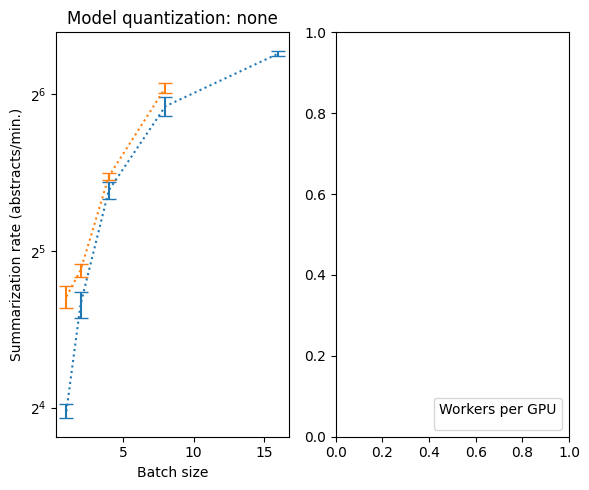

,abstracts,batches,replicate,batch size,workers,jobs per GPU,quantization,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,3,3,1,1,4,1,none,44.361511,0.270505,16.230286
1,3,3,2,1,4,1,none,44.567701,0.269253,16.155197
2,3,3,3,1,4,1,none,45.939972,0.261210,15.672626
3,3,3,4,1,4,1,none,47.880006,0.250627,15.037592
4,3,3,5,1,4,1,none,46.191195,0.259790,15.587386


In [89]:
import numpy as np

data = pd.read_csv('../benchmarks/parallel_batched_summarization/results.csv')

OOM_columns = [
    'summarization time (sec.)',
    'summarization rate (abstracts/sec.)'
]

OOM = data[data['summarization time (sec.)'] == 'OOM']
OOM = OOM[['batch size', 'workers', 'quantization']]
OOM_conditions = OOM.to_numpy().tolist()

for OOM_column in OOM_columns:
    for condition in OOM_conditions:

        data[OOM_column].loc[
            (data['batch size'] == condition[0]) &
            (data['workers'] == condition[1]) &
            (data['quantization'] == condition[2])
        ] = np.nan

data.dropna(inplace=True)

data['summarization time (sec.)'] = data['summarization time (sec.)'].astype(float)
data['summarization rate (abstracts/sec.)'] = data['summarization rate (abstracts/sec.)'].astype(float)

data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60
data['jobs per GPU'] = data['workers'] // 4

quantization_types = data['quantization'].unique()
worker_nums = data['jobs per GPU'].unique()

fig, axs = plt.subplots(1, 2, figsize=(((len(quantization_types) * 5) + 1), 5), tight_layout=True)

axs_count = 0

for quantization in quantization_types:
    quantization_type_data = data[data['quantization'] == quantization].copy()
    quantization_type_data.drop('quantization', axis=1, inplace=True)

    for workers in worker_nums:

        plot_data = quantization_type_data[quantization_type_data['jobs per GPU'] == workers]

        mean = plot_data.groupby(['batch size']).mean()
        mean.reset_index(inplace=True)
        
        std = plot_data.groupby(['batch size']).std()
        std.reset_index(inplace=True)

        axs[axs_count].set_title(f'Model quantization: {quantization}')
        axs[axs_count].set_xlabel('Batch size')
        axs[axs_count].set_ylabel('Summarization rate (abstracts/min.)')
        axs[axs_count].set_yscale('log', base=2)
        axs[axs_count].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        axs[axs_count].errorbar(
            mean['batch size'], 
            mean['summarization rate (abstracts/min.)'], 
            yerr=std['summarization rate (abstracts/min.)'],
            capsize=5,
            label=workers,
            linestyle='dotted'
        )

    axs_count += 1

plt.legend(loc='lower right', title='Workers per GPU')
plt.show()

data.head()

### 6. SQL Insert

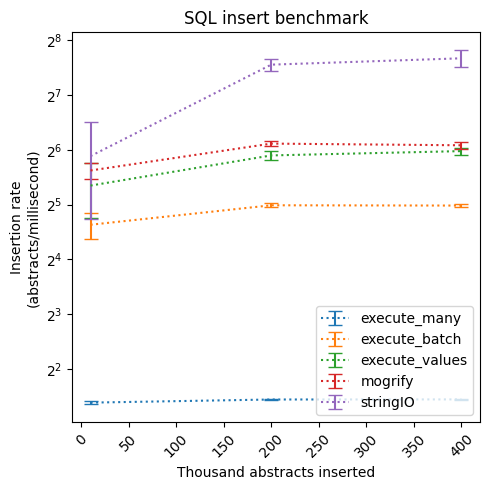

,abstracts,insert time (sec.),insert rate (abstracts/sec.),insert strategy,replicate,insert rate (abstracts/millisecond)
0,10.0,3.772693,2650.626378,execute_many,1,2.650626
1,10.0,3.846135,2600.012807,execute_many,2,2.600013
2,10.0,3.810965,2624.007263,execute_many,3,2.624007
3,10.0,3.817579,2619.461488,execute_many,4,2.619461
4,10.0,3.909431,2557.916853,execute_many,5,2.557917


In [12]:
data = pd.read_csv('../benchmarks/sql_insert/results.csv')
data['insert rate (abstracts/millisecond)'] = data['insert rate (abstracts/sec.)'] / 1000
data['abstracts'] = data['abstracts'] / 1000

insert_strategies = ['execute_many', 'execute_batch', 'execute_values', 'mogrify', 'stringIO']

fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

axs.set_title('SQL insert benchmark')
axs.set_xlabel('Thousand abstracts inserted')
axs.set_ylabel('Insertion rate\n(abstracts/millisecond)')
axs.set_yscale('log', base=2)
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axs.tick_params(axis='x', labelrotation=45)

for insert_strategy in insert_strategies:

    plot_data = data[data['insert strategy'] == insert_strategy]

    mean = plot_data.groupby(['insert strategy', 'abstracts']).mean()
    mean.reset_index(inplace=True)
    
    std = plot_data.groupby(['insert strategy', 'abstracts']).std()
    std.reset_index(inplace=True)

    axs.errorbar(
        mean['abstracts'], 
        mean['insert rate (abstracts/millisecond)'], 
        yerr=std['insert rate (abstracts/millisecond)'],
        capsize=5,
        label=insert_strategy,
        linestyle='dotted'
    )

plt.legend(loc='lower right')
plt.show()

data.head()